### Project overview
An exploratory data analysis of public bikeshare data from two major bike share programs, one in LA and one in Chicago, focusing on the effects of the pandemic.

This notebook mirrors the README but with a bit more detail

#### Data source
This data comes from public sources: 
- the LA metro bike share [data](https://bikeshare.metro.net/about/data/) 
    + 15 columns, 800k rows (across 3 years)
- the Chicago divvy bike share [data](https://www.divvybikes.com/system-data)
    + 13 columns, 11 million rows (across 3 years)

Files can be downloaded as .zip and once unzipped are .csv. A couple Chicago files are not named .csv correctly and must be renamed manually before this script can interpret them correctly. This script does not download or unzip these files.

In [1]:
# Imports and dependencies. This EDA uses Spark

import pyspark as ps
from pyspark.sql.types import *
import pyspark.sql.functions as f
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.style.use('ggplot')

import bike_eda

# Most bike_eda.py functions use this spark session
spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("morning sprint") 
        .getOrCreate()
        )

>Below we can see the format of our data. There is some useful information in here! We'll only get to explore a couple things in this EDA.

In [2]:
# First we want to get the data from our csv files. Let's start with LA

la_sdf = bike_eda.la_csv_to_sdf(spark)

la_sdf.show(10)

+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
| trip_id|duration|         start_time|           end_time|start_station|start_lat| start_lon|end_station| end_lat|   end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+--------+--------+-------------------+-------------------+-------------+---------+----------+-----------+--------+----------+-------+-------------+-------------------+---------------+
|94851140|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6279|           30|            One Way|   Monthly Pass|
|94851141|       8|2018-07-01 00:04:00|2018-07-01 00:12:00|         3058|  34.0358|-118.23317|       3082|34.04652|-118.23741|   6518|          365|            One Way|      Flex Pass|
|94851138|      15|2018-07-01 00:09:00|2018-07-01 00:24:00|         4147| 3

>The only missing data is a chunk of lattitude and longitude coordinates and a small number of missing bike IDs. It's likely there are some stations that don't have that information for whatever reason. Because the rest of the row data is still there and we aren't using geographic information, we won't worry about those rows.

In [3]:
# How much missing data is in each column

la_sdf.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in la_sdf.columns]).show()

+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|trip_id|duration|start_time|end_time|start_station|start_lat|start_lon|end_station|end_lat|end_lon|bike_id|plan_duration|trip_route_category|passholder_type|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+
|      0|       0|         0|       0|            0|    50254|    50254|          0|  24649|  24649|     11|            0|                  0|              0|
+-------+--------+----------+--------+-------------+---------+---------+-----------+-------+-------+-------+-------------+-------------------+---------------+



>Now let's move on to a visualization so we can get a sense of the shape of the data. First we'll do ride count per hour of day across the year for LA.
>
>Below we can see spikes in ridership at 8am and 5pm, and perhaps a little bit around lunch. This makes sense as many people are probably commuters. But these spikes smooth out in 2020 and become more uniform. If we remove January and February from the data (not shown) the 2020 line looks even smaller and smoother. This is likely in large part to the work-from-home part of the pandemic.

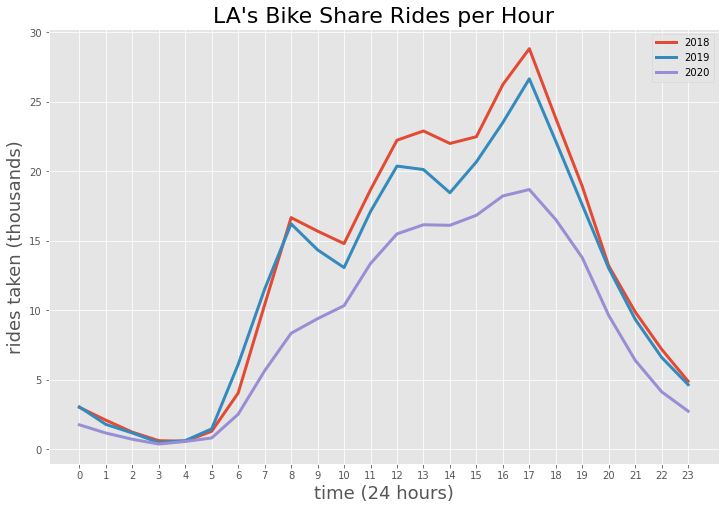

In [15]:
# Hourly visualization for LA

fig, ax = plt.subplots(figsize=(12,8))

bike_eda.la_hour_graph(spark, ax)

>Next we'll take a peek at a more specific slicing of the data for Chicago. We'll chart ridership across different weekdays but break riders into pass holding members and anonymous riders.
>
>Here we can also start to see some of the effects of work-from-home. A lot of divvy members are renting much more on the weekdays, again probably commuting. Moving to 2020 however the difference between weekend and weekday starts to smooth out. Interestingly non-member ridership looks like it increased in 2020. This in of itself could be an avenue of future analysis.

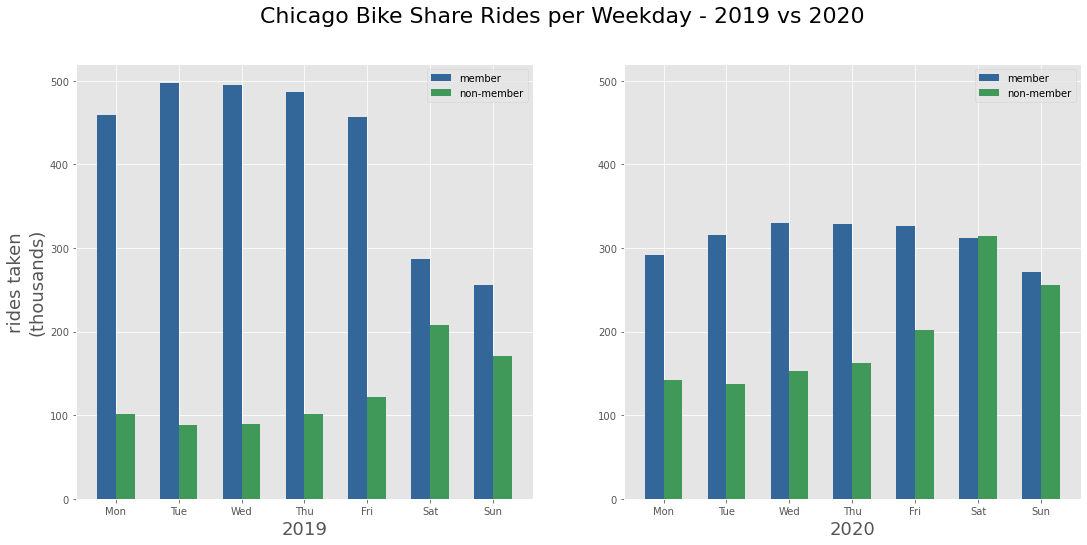

In [16]:
# Weekday visual for Chicago

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))

bike_eda.ch_wd_graph(spark, fig, ax1, ax2)

>These graphs are great and some trends are beginning to emerge. But we should compare LA and Chicago on some metric. One graph that's easy to interpret is the number of rides taken each month for different years.
>
>First in LA you can see 2018 and 2019 follow a pretty basic pattern but 2020 really falls flat after COVID starts to take it's hold and societal changes roll in.

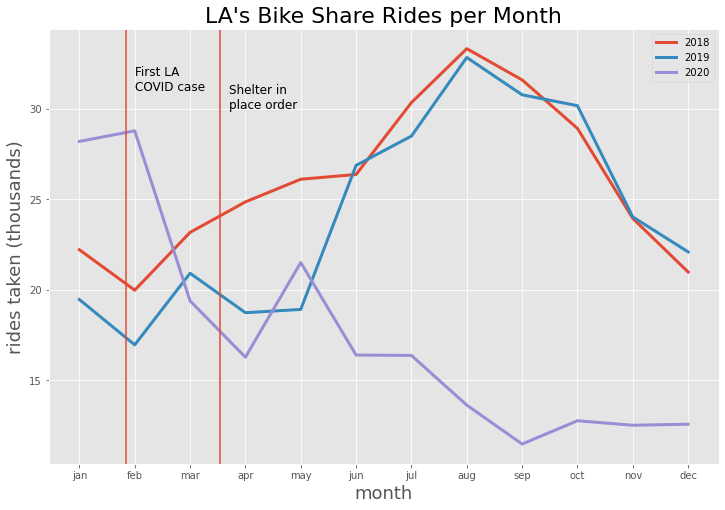

In [17]:
# Primary visual for LA

fig, ax = plt.subplots(figsize=(12,8))

bike_eda.la_month_graph(spark, ax, hline=True)

>Let's look at Chicago during the same time period.
>
>The features of the data are similar to LA's and there is no missing data to note, so we'll jump straight to the visualization.
>
>While Chicago certainly has a dip a couple months into 2020, they appear to recover and even exceed their 2019 numbers by fall. By looking at the scale of rides taken you can also tell Chicago's program is much bigger. Even in the dead of winter more bikes are being riden than in LA's peak season.

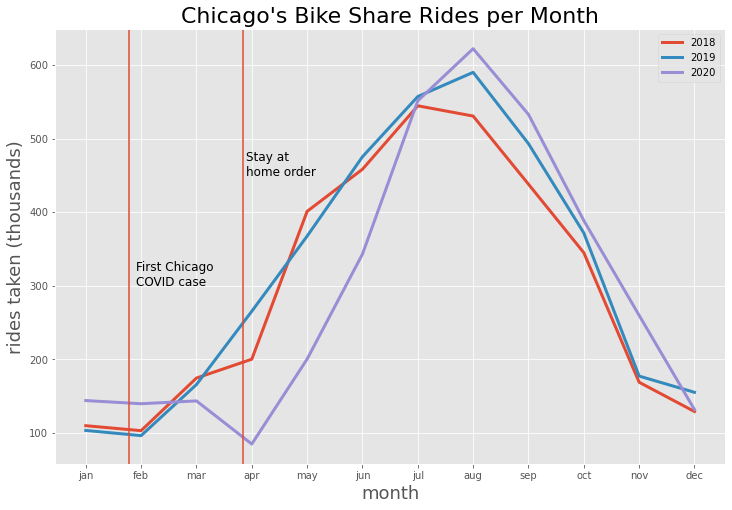

In [18]:
# Primary visual for Chicago

fig, ax = plt.subplots(figsize=(12,8))

bike_eda.ch_month_graph(spark, ax, hline=True)

plt.savefig('graphs/chicago_month.png');

>If there's one takeaway from this analysis it's this: LA's bike share program took a dive and stayed down, while Chicago's program on the other hand bounced back.
>
>It's not hard to see what's going on visually with these two cities so we could stop just there but we should run some statistical tests for two reasons: 
>1. We can back up any specific findings with math. 
>2. If we want to analyze other cities where the impact may not be as clear we have a precedent for analyzing it methodically. 
>
>It does get technical from this point forward. Let's decide on some measurement we want to compare and then what specific tests we want to run.
>
>Daily ride counts are a decent measurement, there's 365 observations in a year and it's easy to interpret. We could compare the entire year 2019 to 2020 for each city (not shown: 2020 is statistically different for LA but not for Chicago). But that doesn't tell the whole story, I want to get more granular then that. It looks like both cities felt the impact from COVID but that Chicago recovers, let's test that out by slicing up the year. The pandemic starting taking effect roughly around the border between quarter 1 (January to March) and quarter 2 (April to Jun). So by comparing Q1 and Q2 we can measure the initial impact of COVID. By next comparing Q2 to Q3 we can measure some of the long term effects of COVID.
>
>One important step: daily ride counts already vary a ton (but predictably) between winter and summer so comparing them directly won't mean anything. We can normalize ride counts by taking a day-by-day difference score from 2019 to 2020 (ie 2019-01-01 minus 2020-01-01, one for each day). This is again a normalized spread of how 2020 has grown as compared to 2019. Using these difference scores instead of raw ride counts, we can compare different quarters without the interference of the seasons (or any other regular confounding factor like holidays).

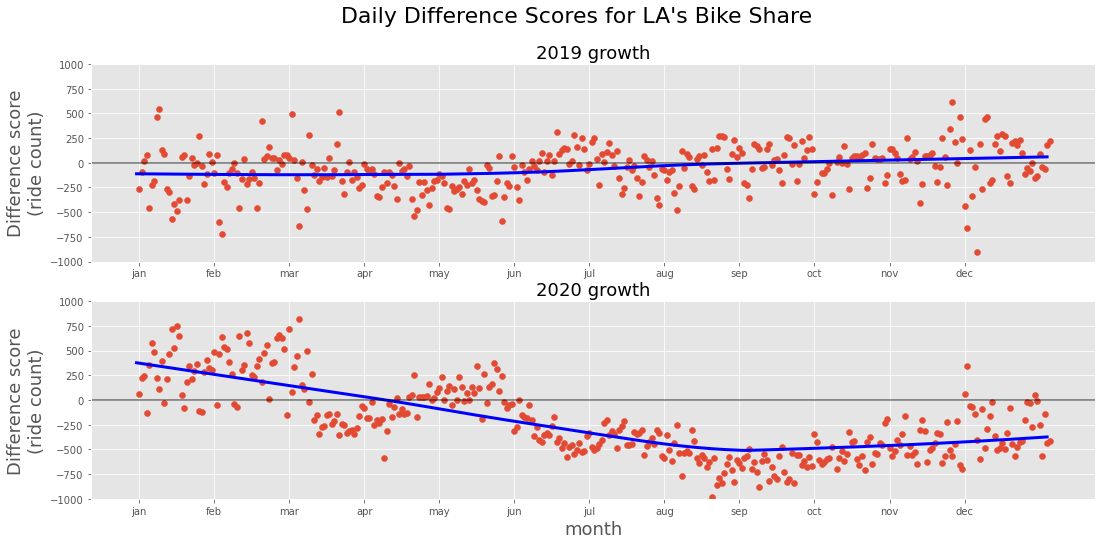

In [3]:
# Get the difference score graphs

fig, (ax1, ax2) = plt.subplots(2, figsize=(18,8))

bike_eda.la_diff_graph(spark, fig, ax1, ax2)

>That looks good, you can see how changes in 2019 hovered around zero, but the 2020 changes were negative (shrinkage rather than growth).
>
>Pulling up Chicago's 2020 difference scores let's highlight the different quarters.

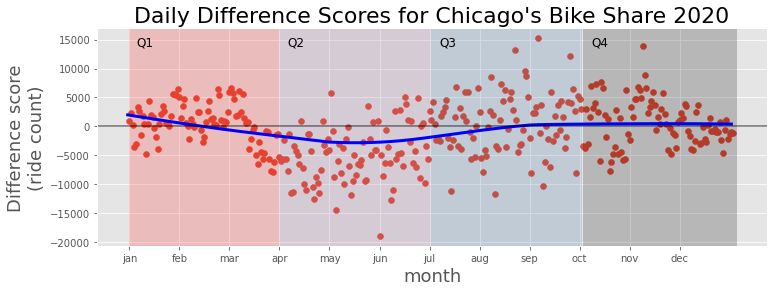

In [2]:
fig, ax = plt.subplots(figsize=(12,4))

bike_eda.ch_q_graph(spark, ax)

>Now it's time to lay out all of our hypotheses we will test.
>
>1. H1: LA ride count difference scores (2020 growth) are statistically significantly different between Q1 and Q2 (initial pandemic impact).
>2. H2: LA ride count difference scores (2020 growth) are statistically significantly different between Q2 and Q3 (long term impact).
>3. H3: Chicago ride count difference scores (2020 growth) are statistically significantly different between Q1 and Q2 (initial pandemic impact).
>4. H4: Chicago ride count difference scores (2020 growth) are statistically significantly different between Q2 and Q3 (long term impact).
>
>Each hypothesis is paired with its own version of the same null hypothesis
>
>- HN: Any two given quarters are not statistically significantly different.
>
>We'll compare quarter data with two sample t-tests. What should our threshold of statistical significance be? The classic value is alpha = 0.05, but since we are testing 4 hypotheses let's include a Bonferroni correction. Instead we will use 0.05 / 4 or alpha = 0.0125. In short, as long as any p-value from the t-tests is below 0.0125 on any given test, it is statistically significant.

In [10]:
# Getting the ride counts per quarter for LA

la_Q1, la_Q2, la_Q3, _ = bike_eda.la_q(spark)

ch_Q1, ch_Q2, ch_Q3, _ = bike_eda.ch_q(spark)

In [11]:
# LA Q1 and Q2 comparison

_, p = stats.ttest_ind(la_Q1, la_Q2, equal_var=False)

print('--LA--')
print("Q1 mean:", round(la_Q1.mean(), 2))
print("Q2 mean:", round(la_Q2.mean(), 2))
print("Comparing Q1 and Q2 in LA:\n p = ", p)

--LA--
Q1 mean: 200.56
Q2 mean: -111.24
Comparing Q1 and Q2 in LA:
 p =  6.565772770112926e-12


In [12]:
# Chicago Q1 and Q2 comparison

_, p = stats.ttest_ind(ch_Q1, ch_Q2, equal_var=False)

print('--Chicago--')
print("Q1 mean:", round(ch_Q1.mean(), 2))
print("Q2 mean:", round(ch_Q2.mean(), 2))
print("Comparing Q1 and Q2 in Chicago:\n p = ", p)

--Chicago--
Q1 mean: 646.46
Q2 mean: -5004.43
Comparing Q1 and Q2 in Chicago:
 p =  1.742954896128413e-16


>When we compare Q1 (pre-pandemic) to Q2 (post-pandemic) for both LA and Chicago they have p values less than our alpha of 0.0125. We fail to reject the null that quarter ride counts are sampled from the same distribution, and have evidence to support them being different. Because quarter means move from positive to negative, the effect is a negative one. 
>
>That is to say ride counts went down from the first to second quarter (backed up by math) and it's pretty safe to say the pandemic was the cause. But this isn't surprising, let's move on to see how each city fared a couple months in.

In [13]:
# LA Q2 and Q3 comparison

_, p = stats.ttest_ind(la_Q2, la_Q3, equal_var=False)

print('--LA--')
print("Q2 mean:", round(la_Q2.mean(), 2))
print("Q3 mean:", round(la_Q3.mean(), 2))
print("Comparing Q2 and Q3 in LA:\n p = ", p)

--LA--
Q2 mean: -111.24
Q3 mean: -550.9
Comparing Q2 and Q3 in LA:
 p =  1.6286497657457807e-30


In [14]:
# Chicago Q2 and Q3 comparison

_, p = stats.ttest_ind(ch_Q2, ch_Q3, equal_var=False)

print('--Chicago--')
print("Q2 mean:", round(ch_Q2.mean(), 2))
print("Q3 mean:", round(ch_Q3.mean(), 2))
print("Comparing Q2 and Q3 in Chicago:\n p = ", p)

--Chicago--
Q2 mean: -5004.43
Q3 mean: 669.24
Comparing Q2 and Q3 in Chicago:
 p =  1.2502931275446294e-12


>Once again, our t-test comparisons yield p values lower than our 0.0125 threshold on both accounts. We fail to reject the null that quarter ride counts are sampled from the same distribution, and have evidence to support them being different.
>
>The difference here is that LA moves from bad to worse. Chicago moves from bad to good again. Chicago recovers while LA does not.

### Conclusion

We can say with a pretty good degree of confidence that both cities took a hit to ridership from the pandemic but the longer term impact was different, with Chicago recovering and LA trudging through low numbers. While this is fairly obvious from looking at visualizations, there is a framework here for looking at other big bike share programs such as San Francisco's or New York's.

Also, although our test determined ridership changed it doesn't explain why. The pandemic is the obvious cause but its exact effects require more investigation (recall the members vs non-members above). These results though could be a good catalyst to start an investigation into why Chicago did so well.

#### Assumptions

This analysis operates on top of some assumptions which when it comes down to it are not upheld. So even though the math plays out, when interpreting the results it's important to not overextend.

- "Programs are consistent over time." These programs are in most cases growing, and in many cities younger than a decade old. LA specifically moved to upgrade a significant portion of their network while ridership was down (https://bikeshare.metro.net/westside-improvement-project/) which in all likelihood exacerbated the pandemic decline.
- "Programs are independent city to city." While LA and Chicago are pretty different, they are not independent. Both are subject to more universal variables like national level bike trends or pressures to reduce carbon emmissions.
- "LA and Chicago's programs are comparable." The truth is as a whole Chicago's system is much bigger. Chicago has about 4 times as many bikes, 6 times as many stations, and 14 times as many bike rides per year. This is in spite of the fact that LA is the more populous city.